# Measuring Discourse Classification Model Bias Across Demographic Categories #

### Main Findings* ###
**Economic disadvantage:** On average, the ML model is 1.5% more acccurate in identifying the discourse elements of non-economically disadvantaged students than those of their economically disadvantaged peers.

**ELL status:** There is no statistically significant difference between the average overlap scores for the discourse elements of students with vs. without ELL status.

**Race/ethnicity:** On average, the model is about 3% more accurate in identifying the discourse elements of Asian/Pacific Islander (API) students than American Indian/Native Alaskan students. It is also 2.13% more accurate for API students than Hispanic/Latino students, about 1.8% more accurate for API students than Black, 1.5% more accurate for API students than white, and 1.2% more accurate for API students than multiracial ones. Lastly, it was 1.8% more accurate in identifying multiracial students' discourse elements than those of Native students, on average. All other differences between average scores by category were either not statiscally significant or had a magnitude of <1%.

**Common intersectional groups**: On average, the model is 2.85% more accurate in identifying the discourse elements of API students who are neither economically disadvantaged nor have ELL status than those of Hispanic/Latino students who both *are* economically disadvantaged *and* have ELL status.

While other differences in model performance between specific intersectional groups may be of interest, they are not likely to significantly exceed the magnitude observed here and may not be statistically significant.

*All findings come with significant caveats, considering the available data, detailed in the conclusion.

### Assignment ###
**Background**: The attached data file contains prediction outputs generated by a machine learning model for a classification task concerning discourse elements within student essays (Lead, Position, Claim, Counterclaim, Rebuttal, Evidence, Concluding Statement). A discourse element is a section of text within an essay performing a specific function in supporting a writer's argument. For a detailed understanding of these discourse elements, please refer to this annotation scheme rubric.


The model's task was to predict both the discourse element's segment boundaries (indicated in the CSV as 'discourse_start' and 'discourse_end') and the correct class label ('discourse_type').


This file exclusively contains true positives from the machine predictions. However, the 'overlap_score_discourse_type' column is a fractional accuracy score associated with these true positives, measuring how much the predicted segment overlaps with the ground truth (i.e., the human-annotated segment boundaries) in its text.


Additionally, the file contains metadata related to the student essays, such as student demographic details.


**Task**: Can you analyze the machine learning model's performance across student subgroup categories of race/ethnicity, economic advantage, and English Language Learner status, based on the overlap accuracy score? The goal is to assess whether the model exhibits bias, showing lower accuracy for specific groups.

## Data Exploration and Cleaning ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from scipy import stats

In [2]:
df=pd.read_csv('data_ml_analysis.csv')

In [3]:
df #look at the data

,id,full_text,holistic_essay_score,discourse_start,discourse_end,discourse_type,overlap_score_discourse_type,source_text,prompt_name,assignment,gender,grade_level,ell_status,race_ethnicity,economically_disadvantaged
0,BC75783F96E3,This essay will explain if drivers should or s...,4,0,43,Lead,0.919264,NaN,Phones and driving,Today the majority of humans own and operate c...,M,NaN,NaN,Black/African American,NaN
1,BC75783F96E3,This essay will explain if drivers should or s...,4,40,54,Position,0.899345,NaN,Phones and driving,Today the majority of humans own and operate c...,M,NaN,NaN,Black/African American,NaN
2,BC75783F96E3,This essay will explain if drivers should or s...,4,53,57,Claim,0.596718,NaN,Phones and driving,Today the majority of humans own and operate c...,M,NaN,NaN,Black/African American,NaN
3,BC75783F96E3,This essay will explain if drivers should or s...,4,55,57,Claim,0.729917,NaN,Phones and driving,Today the majority of humans own and operate c...,M,NaN,NaN,Black/African American,NaN
4,BC75783F96E3,This essay will explain if drivers should or s...,4,57,62,Claim,0.931856,NaN,Phones and driving,Today the majority of humans own and operate c...,M,NaN,NaN,Black/African American,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93518,DF920E0A7337,Have you ever asked more than one person for h...,4,302,310,Claim,0.576745,NaN,Seeking multiple opinions,"When people ask for advice, they sometimes tal...",M,8.0,No,White,Not economically disadvantaged
93519,DF920E0A7337,Have you ever asked more than one person for h...,4,310,460,Evidence,0.936581,NaN,Seeking multiple opinions,"When people ask for advice, they sometimes tal...",M,8.0,No,White,Not economically disadvantaged
93520,DF920E0A7337,Have you ever asked more than one person for h...,4,458,466,Claim,0.571693,NaN,Seeking multiple opinions,"When people ask for advice, they sometimes tal...",M,8.0,No,White,Not economically disadvantaged
93521,DF920E0A7337,Have you ever asked more than one person for h...,4,466,626,Evidence,0.931250,NaN,Seeking multiple opinions,"When people ask for advice, they sometimes tal...",M,8.0,No,White,Not economically disadvantaged


In [4]:
df.isna().sum() #number of missing values in each variable

id                                  0
full_text                           0
holistic_essay_score                0
discourse_start                     0
discourse_end                       0
discourse_type                      0
overlap_score_discourse_type        0
source_text                     51493
prompt_name                         0
assignment                          0
gender                              0
grade_level                      4425
ell_status                       4572
race_ethnicity                      0
economically_disadvantaged      14942
dtype: int64

In [5]:
df.shape[0] #total number of observations
#"economically_disadvantaged" is missing values for about 20% of observations.
#Keep this in mind when drawing conclusions from the analysis

93523

In [6]:
pd.value_counts(df["economically_disadvantaged"])#2 categories

economically_disadvantaged
Not economically disadvantaged    43167
Economically disadvantaged        35414
Name: count, dtype: int64

In [7]:
pd.value_counts(df["race_ethnicity"])#6 categories, but all have a significant number of observations
#should be adequate to get reliable estimates for effects of each category

race_ethnicity
White                             42232
Hispanic/Latino                   22803
Black/African American            17015
Asian/Pacific Islander             6934
Two or more races/Other            3951
American Indian/Alaskan Native      588
Name: count, dtype: int64

In [8]:
pd.value_counts(df["ell_status"])#Some missing values were entered as blank values, not NAs

ell_status
No     81507
Yes     7322
         122
Name: count, dtype: int64

In [9]:
df["ell_status"].replace(' ', np.NaN, inplace=True) #change all blanks to NAs

In [10]:
pd.value_counts(df["ell_status"])#check that it worked
#Only 2 categories, as desired

ell_status
No     81507
Yes     7322
Name: count, dtype: int64

In [11]:
df["ell_status"].isna().sum()#it did work

4694

## Analysis of Potential Bias in the ML Model ##
### Economic disadvantage ##

In [12]:
#Start with 2-category variables bc they are simplest
#Select all obs of a particular category
ed_scores=df.loc[df["economically_disadvantaged"]=="Economically disadvantaged"]

In [13]:
pd.value_counts(ed_scores["economically_disadvantaged"])#It worked

economically_disadvantaged
Economically disadvantaged    35414
Name: count, dtype: int64

In [14]:
ed_scores=ed_scores["overlap_score_discourse_type"] #Trim down to only scores for ease of use

In [15]:
ed_scores #It worked

12692    0.950814
12693    0.561817
12694    0.756259
12695    0.596767
12696    0.575581
           ...   
93506    0.532533
93507    0.947266
93508    0.584858
93509    0.941305
93510    0.934715
Name: overlap_score_discourse_type, Length: 35414, dtype: float64

In [16]:
#repeat for other category
ned_scores=df.loc[df["economically_disadvantaged"]=="Not economically disadvantaged"]

In [17]:
pd.value_counts(ned_scores["economically_disadvantaged"])

economically_disadvantaged
Not economically disadvantaged    43167
Name: count, dtype: int64

In [18]:
ned_scores=ned_scores["overlap_score_discourse_type"]
ned_scores

12680    0.818696
12681    0.628777
12682    0.928329
12683    0.944442
12684    0.937791
           ...   
93518    0.576745
93519    0.936581
93520    0.571693
93521    0.931250
93522    0.928011
Name: overlap_score_discourse_type, Length: 43167, dtype: float64

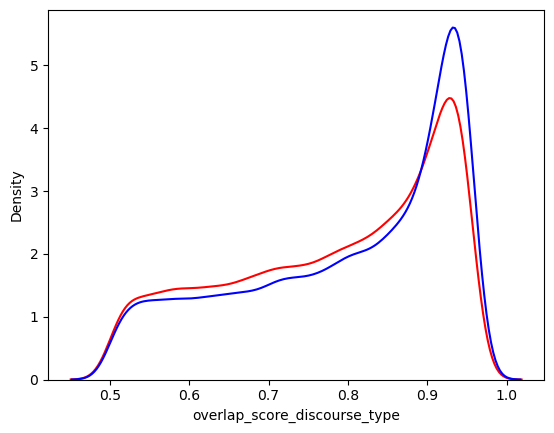

In [19]:
#we need to check the distribution of the data to inform what statistical test is most appropriate to use
fig= sns.kdeplot(ed_scores, color='r')
fig= sns.kdeplot(ned_scores, color='b')

The ML model's accuracy scores are not normally distributed for either economic group. However, given the large number of observations in the sample data, this will not keep us from being able to use parametric tests. More importantly, though, it does appear that both groups have a similar distribution, which means we can proceed to use a conventional statistical test like the Student's T.

In [20]:
ed_t, ed_p = stats.ttest_ind(ed_scores, ned_scores)  
print("p-value = " + str(ed_p))

p-value = 4.6867194967273134e-55


A T-test of the mean overlap scores for economically and not economically disadvantaged students' discourse elements suggests that there is a statistcally significant difference in the model's accuracy in classification between these groups. However, given the large sample sizes, a statistcally significant difference is not especially surprising. What is more interesting is the magnitude of this difference.

In [21]:
print(np.mean(ned_scores)-np.mean(ed_scores))

0.015066200771362004


**FINDING 1:** On average, the ML model is 1.5% more acccurate in identifying the discourse elements of non-economically disadvantaged students than those of their economically disadvantaged peers, within the data on hand.

### ELL Status ###

In [22]:
ell_scores=df.loc[df["ell_status"]=="Yes"]
ell_scores=ell_scores["overlap_score_discourse_type"]

In [23]:
nell_scores=df.loc[df["ell_status"]=="No"]
nell_scores=nell_scores["overlap_score_discourse_type"]

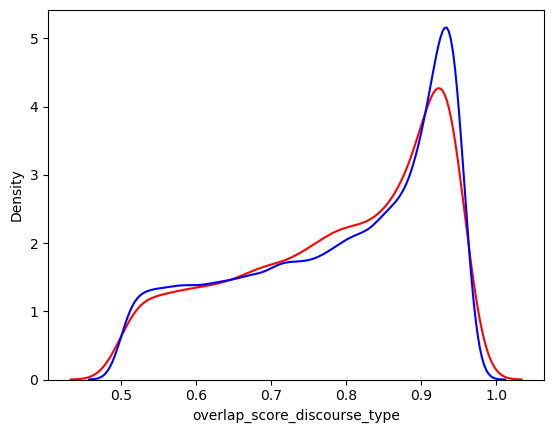

In [24]:
fig= sns.kdeplot(ell_scores, color='r')
fig= sns.kdeplot(nell_scores, color='b')

Once again, the scores for each category of the variable appear to be drawn from the same, non-normal distribution, so we can continue with a T-test of difference.

In [25]:
ell_t, ell_p = stats.ttest_ind(ell_scores, nell_scores)  
print("p-value = " + str(ell_p))

p-value = 0.2986457305925782


A high p-value here means that the mean overlap scores for ELL and non-ELL students are not significantly different. Could this be simply due to the relatively small number of observations of ELL students in the data? Let's examine the raw difference in means to get a better idea.

In [26]:
print(np.mean(nell_scores)-np.mean(ell_scores))

0.0017053885550690762


**FINDING 2:** On average, the model is about 0.2% more accurate in identifying the discourse elements of non-ELL students than ELL students, within the available data, so it appears that the failure to achieve statistical significance is likely due to a genuine lack of a difference rather than a shortage of data.

### Race/Ethnicity ###

In [29]:
white_scores=df.loc[df["race_ethnicity"]=="White"]
white_scores=white_scores["overlap_score_discourse_type"]

In [30]:
HL_scores=df.loc[df["race_ethnicity"]=="Hispanic/Latino"]
HL_scores=HL_scores["overlap_score_discourse_type"]

In [31]:
black_scores=df.loc[df["race_ethnicity"]=="Black/African American"]
black_scores=black_scores["overlap_score_discourse_type"]

In [32]:
API_scores=df.loc[df["race_ethnicity"]=="Asian/Pacific Islander"]
API_scores=API_scores["overlap_score_discourse_type"]

In [34]:
multiracial_scores=df.loc[df["race_ethnicity"]=="Two or more races/Other"]
multiracial_scores=multiracial_scores["overlap_score_discourse_type"]

In [35]:
NA_scores=df.loc[df["race_ethnicity"]=="American Indian/Alaskan Native"]
NA_scores=NA_scores["overlap_score_discourse_type"]

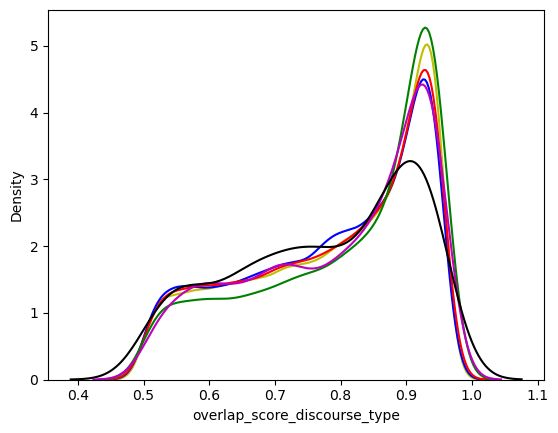

In [49]:
fig= sns.kdeplot(white_scores, color='y')
fig= sns.kdeplot(HL_scores, color='b')
fig= sns.kdeplot(black_scores, color='r')
fig= sns.kdeplot(API_scores, color='g')
fig= sns.kdeplot(multiracial_scores, color='m')
fig= sns.kdeplot(NA_scores, color="k")

The scores for each racial category appear to be drawn from the same distribution, with the possible exception of the "American Indian/Alaskan Native" category. It is possible, though, that this category's deviation is due simply to its smaller sample size relative to the other categories. Statistical tests may shine a light on this and its shape does appear similar enough that we can assume it is identically distributed for our purposes.

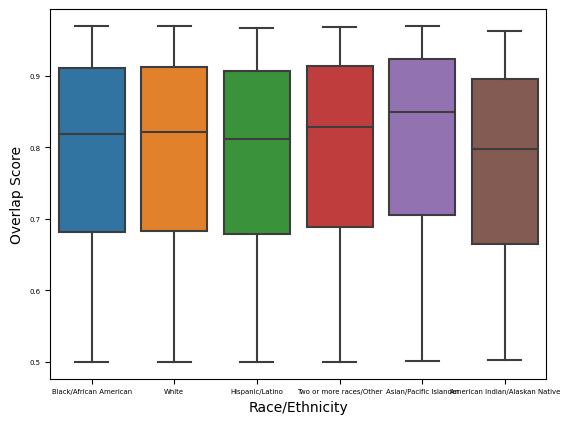

In [66]:
b= sns.boxplot(x=df["race_ethnicity"], y=df["overlap_score_discourse_type"])
b.set_xlabel("Race/Ethnicity")
b.set_ylabel("Overlap Score")
b.tick_params(labelsize=5)

At a glance, it does appear that the means of some categories are slightly different, so we should perform a test to confirm these differences are significant.

In [51]:
print(np.std(white_scores), np.std(black_scores), np.std(HL_scores), np.std(API_scores), np.std(multiracial_scores), np.std(NA_scores))

0.13432501315848586 0.1342989312537143 0.13347964603603285 0.1345789975131838 0.1335919906980933 0.1347602392639332


The categories have very similar variances. This means that we can perform a one-way ANOVA test without losing statistical power, despite the unequal sizes of the categories.

In [53]:
re_f, re_p=f_oneway(white_scores, HL_scores, black_scores, API_scores, multiracial_scores, NA_scores)
print("p-value:" + str(re_p))

p-value:1.7533310140756298e-30


The very low p-value here only tells us that there is a statisically significant difference between at least two of the categories of the variable. A pairwise Tukey test gives us more specific information about the differences between categories.

In [70]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df['overlap_score_discourse_type'],
                          groups=df['race_ethnicity'],
                          alpha=0.05)
print(tukey)

                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                     
            group1                      group2         meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------
American Indian/Alaskan Native  Asian/Pacific Islander   0.0303    0.0  0.0139  0.0467   True
American Indian/Alaskan Native  Black/African American   0.0125 0.2297 -0.0036  0.0285  False
American Indian/Alaskan Native         Hispanic/Latino    0.009 0.5928  -0.007   0.025  False
American Indian/Alaskan Native Two or more races/Other   0.0183 0.0242  0.0015  0.0352   True
American Indian/Alaskan Native                   White   0.0151 0.0713 -0.0007   0.031  False
        Asian/Pacific Islander  Black/African American  -0.0178    0.0 -0.0233 -0.0124   True
        Asian/Pacific Islander         Hispanic/Latino  -0.0213    0.0 -0.0266 -0.0161   True
        Asian/Pacific Islander Two or more races/Other   -0.

We can zero in on the statistically significant differences between groups (those for which the null hypothesis was rejected). 

**FINDING 3:** The largest difference in overlap scores is between the American Indian/Alaskan Native and Asian/Pacific Islander (API) categories. On average, the model is about 3% more accurate in identifying the discourse elements of the API students than Native students, within the data at hand. It is also 2.13% more accurate for API students than Hispanic/Latino students, about 1.8% more accurate for API students than Black, 1.5% more accurate for API students than white, and 1.2% more accurate for API students than multiracial ones. Lastly, it was 1.8% more accurate in identifying multiracial students' discourse elements than those of Native students, on average. All other differences between average scores by category were either not statiscally significant or had a magnitude of <1%.

### Intersectional categories ###

The above analyses of differences between categories of a single variable do not reveal bias of greater than 3% accuracy for any demographic difference. This on its own may not be especially concerning, but the intersection of multiple categorical variables could amplify this bias.

<Axes: xlabel='economically_disadvantaged', ylabel='count'>

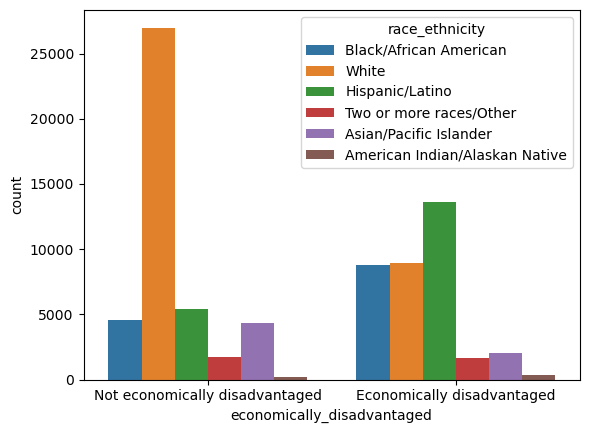

In [80]:
sns.countplot(x=df["economically_disadvantaged"], hue=df["race_ethnicity"])

<Axes: xlabel='ell_status', ylabel='count'>

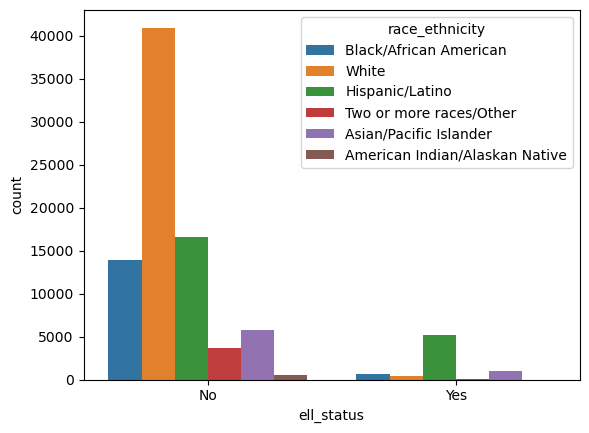

In [81]:
sns.countplot(x=df["ell_status"], hue=df["race_ethnicity"])

Examining the distribution of categories across other categories, we can see, for instance, that Hispanic/Latino students are much more likely to be economically disadvantaged, have ELL status, or both, than white or API students. Hispanic/Latino students with ELL status and economic disadvantages are prevalent in the data and may be significantly more likely to have their discourse elements misidentified than their peers without these attributes. We can compare the model's performance for these students to that for the category whose discourse is most accurately identified on average (API students who are neither economically disadvantaged nor have ELL status) to get a sense for the largest common instance of demographic bias in the model, given the data at hand.

In [86]:
HL_ELL_ED_scores=df.loc[df["race_ethnicity"]=="Hispanic/Latino"]
HL_ELL_ED_scores=HL_ELL_ED_scores.loc[HL_ELL_ED_scores["economically_disadvantaged"]=="Economically disadvantaged"]
HL_ELL_ED_scores=HL_ELL_ED_scores.loc[HL_ELL_ED_scores["ell_status"]=="Yes"]

In [87]:
HL_ELL_ED_scores.describe()#4125 observations in the data, which is sizeable enough for reliable analysis

,holistic_essay_score,discourse_start,discourse_end,overlap_score_discourse_type,grade_level
count,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000
mean,2.834909,136.447515,177.419394,0.782001,10.093091
std,0.897590,131.829165,144.669556,0.131546,1.310838
min,1.000000,0.000000,6.000000,0.500138,6.000000
25%,2.000000,35.000000,63.000000,0.680620,10.000000
50%,3.000000,99.000000,147.000000,0.805680,10.000000
75%,3.000000,201.000000,251.000000,0.901510,11.000000
max,6.000000,848.000000,1068.000000,0.966841,12.000000


In [88]:
HL_ELL_ED_scores=HL_ELL_ED_scores["overlap_score_discourse_type"]

In [91]:
API_NELL_NED_scores=df.loc[df["race_ethnicity"]=="Asian/Pacific Islander"]
API_NELL_NED_scores=API_NELL_NED_scores.loc[API_NELL_NED_scores["economically_disadvantaged"]=="Not economically disadvantaged"]
API_NELL_NED_scores=API_NELL_NED_scores.loc[API_NELL_NED_scores["ell_status"]=="No"]

In [92]:
API_NELL_NED_scores.describe()#3911 observations. Also adequate.

,holistic_essay_score,discourse_start,discourse_end,overlap_score_discourse_type,grade_level
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,4.562516,208.968550,256.634620,0.810526,9.551777
std,1.121342,192.898023,211.167653,0.134763,1.493658
min,1.000000,0.000000,7.000000,0.500772,6.000000
25%,4.000000,66.000000,89.000000,0.711717,8.000000
50%,5.000000,138.000000,189.000000,0.858022,10.000000
75%,5.000000,312.000000,375.000000,0.926789,11.000000
max,6.000000,948.000000,1043.000000,0.967413,11.000000


In [95]:
API_NELL_NED_scores=API_NELL_NED_scores["overlap_score_discourse_type"]

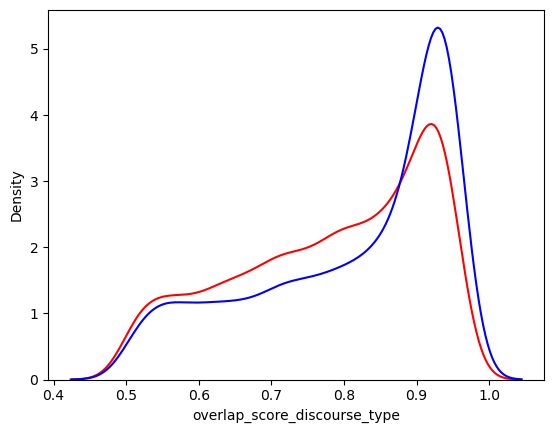

In [96]:
fig= sns.kdeplot(HL_ELL_ED_scores, color='r')
fig= sns.kdeplot(API_NELL_NED_scores, color='b') #Check distributions

In [97]:
int_t, int_p = stats.ttest_ind(HL_ELL_ED_scores, API_NELL_NED_scores)  
print("p-value = " + str(int_p))

p-value = 1.0370244524549102e-21


The difference in means between groups is statistically significant despite relatively smaller sample sizes.

In [98]:
print(np.mean(API_NELL_NED_scores)-np.mean(HL_ELL_ED_scores))

0.028524638845706773


**FINDING 4:** On average, the model is 2.85% more accurate in identifying the discourse elements of API students who are neither economically disadvantaged nor have ELL status than those of Hispanic/Latino students who *are* economically disadvantaged *and* have ELL status.

This is slightly larger than the difference between just API and Hispanic/Latino students, so it does suggest demographic intersection can amplify the model's error, although probably not to an extreme extent. While there are intersectional groups for which me might expect an even larger difference in accuracy scores (e.g. API/non-ED/non-ELL students vs. Native/ED/ELL students), these groups do not appear often enough in the data to draw reliable inferences from them.

While other differences in model performance between specific intersectional groups may be of interest, they are not likely to significantly exceed the magnitude observed here.

For example, we can do a quick and dirty comparison of the model's average performance for the discourse elements of white/non-ED/non-ELL students to Hispanic/Latino/ED/ELL students'.

In [99]:
W_NELL_NED_scores=df.loc[df["race_ethnicity"]=="White"]
W_NELL_NED_scores=W_NELL_NED_scores.loc[W_NELL_NED_scores["economically_disadvantaged"]=="Not economically disadvantaged"]
W_NELL_NED_scores=W_NELL_NED_scores.loc[W_NELL_NED_scores["ell_status"]=="No"]

In [100]:
W_NELL_NED_scores=W_NELL_NED_scores["overlap_score_discourse_type"]

In [101]:
print(np.mean(W_NELL_NED_scores)-np.mean(HL_ELL_ED_scores))

0.014561440633973133


We find a 1.45% average difference, which is, as expected, less than the difference observed above.

## Conclusion/Caveats ##

#### How much bias is too much? ####
The significance of the above findings depends on how much bias we are willing to tolerate in the output of the model. It is not clear whether the model could be further tuned to potentially decrease this bias and whether doing so would deteriorate its performance in other dimensions.

#### Incomplete data, incomplete analysis ####
Further, I do not recommend making a final decision on the fitness of the model based on the above results alone, given that they were made using incomplete data.

1. The above analyses omitted observations from sources that did not collect data on some variables, including about 20% of all observations in the data set for the "economic disadvantage" variable. If the relationships between the categories and the outcome of interest in the omitted data differs from the relationships observed above, then the findings are erroneous. However, there is not a clear theoretical reason to expect that to be the case.

2. The above analyses were performed only on the "true positive" outputs of the model as identified by human cross-checkers. If the model were to be put to use in the field, these guard rails would not be in place and thus there would be no distinction between true positives and other outputs. Thus, false positives and false negatives would be included in the output used and those would affect the unmeasureable error of the model. A complete analysis of the error of the model needs all outputs to be included.